In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib
import seaborn as sns
import scipy as sc
import random
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings (category=DeprecationWarning, action='ignore')
import tqdm
import collections
from functools import reduce
from sklearn import model_selection, datasets, metrics, tree, ensemble, preprocessing, feature_extraction, feature_selection, utils, neighbors, decomposition, linear_model, pipeline, cluster, compose, impute,svm, naive_bayes, manifold
import keras 
from keras import models, layers, utils
import lightgbm as lgbm
import xgboost as xgb
from IPython.display import Audio
sound_file = 'https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg'

In [ ]:
!pip install catboost
import catboost as catb
from catboost import Pool, cv

In [ ]:
train = pd.read_csv ('/content/train.csv')
test = pd.read_csv ('/content/test.csv' )
y_train =  train.iloc[:, -1]

## missing values (euristic)

In [ ]:
df=train.copy()
dff= pd.concat ([train.copy().iloc[:, :-1] , test.copy()] , ignore_index=True)

In [ ]:
dff['NID'] = dff['PassengerId'].str.split('_').str.get(0)
df['NID'] = df['PassengerId'].str.split('_').str.get(0)
dff['LN'] = dff['Name'].str.split(' ').str.get(1)
df['LN'] = df['Name'].str.split(' ').str.get(1)


In [ ]:
dff.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
NID               0
LN              294
dtype: int64

In [ ]:
dff[['HomePlanet' ,'Cabin' , 'LN' ]] = dff[['HomePlanet' ,'Cabin' , 'LN' ]].fillna ('__')
df[['HomePlanet' ,'Cabin' , 'LN' ]] = df[['HomePlanet' ,'Cabin' , 'LN' ]].fillna ('__')

In [ ]:
df.groupby ('NID').mean()['Transported'].value_counts() # NID влияет на выживаемость, в 87% случаев NID полностью либо выжил, либо нет

0.000000    2868
1.000000    2552
0.500000     410
0.666667     139
0.333333      98
0.750000      35
0.250000      16
0.600000      16
0.800000      13
0.400000      10
0.571429       9
0.833333       9
0.428571       8
0.200000       7
0.714286       5
0.375000       5
0.166667       4
0.285714       4
0.857143       4
0.625000       2
0.125000       2
0.142857       1
Name: Transported, dtype: int64

In [ ]:
df.groupby ('LN').mean()['Transported'].value_counts()  # а вот внутри семьи все по разному, LN не гарантия

In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['HomePlanet'].value_counts () # жители одной каюты (NID) имеют одинаковый Home Planet, половину пропущенных признаков можно точно восстанвоить

(Earth,)        5333
(Mars,)         1850
(Europa,)       1812
(__,)            156
(Europa, __)      28
(Earth, __)       27
(Mars, __)        26
(__, Earth)       20
(__, Europa)      14
(__, Mars)        14
Name: HomePlanet, dtype: int64

In [ ]:
dff.groupby ('LN').aggregate (lambda x : tuple (x.unique()))['HomePlanet'].value_counts () # у семей один пункт вылета, за 1 исключением, которым можно пренебречь, можно восстановить почти все

(Earth,)                     866
(Europa,)                    795
(Mars,)                      481
(Earth, __)                  116
(Mars, __)                    59
(Europa, __)                  47
(__, Earth)                   16
(__, Europa)                  13
(__, Mars)                     7
(__,)                          6
(Mars, Earth, Europa, __)      1
Name: HomePlanet, dtype: int64

In [ ]:
dff.groupby ('LN').aggregate (lambda x : tuple (x.unique()))['VIP'].value_counts () # VIP статус не связан жестко с LN и NID, но ценность его изначально невысока

(False,)              1913
(False, nan)           192
(False, True)          145
(True, False)           68
(nan, False)            53
(nan,)                   7
(True,)                  7
(False, nan, True)       7
(False, True, nan)       7
(True, False, nan)       6
(True, nan, False)       1
(nan, False, True)       1
Name: VIP, dtype: int64

In [ ]:
dff.groupby(['LN' , 'NID', 'Cabin']).aggregate (lambda x : tuple (x.unique()))

PassengerId HomePlanet CryoSleep  \
LN       NID  Cabin                                               
Acobson  4220 E/263/P           (4220_01,)   (Earth,)  (False,)   
         4353 F/817/S           (4353_01,)   (Earth,)  (False,)   
         6905 E/460/S           (6905_02,)   (Earth,)  (False,)   
              F/1322/S  (6905_01, 6905_03)   (Earth,)  (False,)   
Acobsond 0991 G/152/S           (0991_01,)   (Earth,)   (True,)   
...                                    ...        ...       ...   
__       9205 B/300/P           (9205_02,)  (Europa,)   (True,)   
         9208 G/1485/S          (9208_01,)   (Earth,)   (True,)   
         9218 B/353/S           (9218_01,)  (Europa,)   (True,)   
         9230 C/342/S           (9230_01,)  (Europa,)  (False,)   
         9246 G/1490/S          (9246_01,)   (Earth,)    (nan,)   

                                       Destination           Age       VIP  \
LN       NID  Cabin                                                          
Acobson  4220 E/263/P               (TRAPPIST-1e,)       (31.0,)  (False,)   
         4353 F/817/S               (TRAPPIST-1e,)       (18.0,)  (False,)   
         6905 E/460/S               (TRAPPIST-1e,)       (15.0,)  (False,)   
              F/1322/S  (TRAPPIST-1e, 55 Cancri e)  (39.0, 16.0)  (False,)   
Acobsond 0991 G/152/S               (TRAPPIST-1e,)       (27.0,)    (nan,)   
...                                            ...           ...       ...   
__       9205 B/300/P               (TRAPPIST-1e,)       (15.0,)  (False,)   
         9208 G/1485/S              (TRAPPIST-1e,)       (35.0,)  (False,)   
         9218 B/353/S               (55 Cancri e,)       (43.0,)  (False,)   
         9230 C/342/S               (TRAPPIST-1e,)       (36.0,)   (True,)   
         9246 G/1490/S              (TRAPPIST-1e,)       (32.0,)  (False,)   

                          RoomService     FoodCourt  ShoppingMall        Spa  \
LN       NID  Cabin                                                            
Acobson  4220 E/263/P        (553.0,)      (224.0,)        (9.0,)     (1.0,)   
         4353 F/817/S        (736.0,)       (40.0,)        (0.0,)     (0.0,)   
         6905 E/460/S          (0.0,)        (0.0,)        (0.0,)   (938.0,)   
              F/1322/S  (130.0, 43.0)  (741.0, 3.0)  (0.0, 750.0)     (0.0,)   
Acobsond 0991 G/152/S          (0.0,)        (0.0,)        (0.0,)     (0.0,)   
...                               ...           ...           ...        ...   
__       9205 B/300/P          (0.0,)        (0.0,)        (0.0,)     (0.0,)   
         9208 G/1485/S         (0.0,)        (0.0,)        (0.0,)     (0.0,)   
         9218 B/353/S          (0.0,)        (0.0,)        (0.0,)     (0.0,)   
         9230 C/342/S          (0.0,)     (5600.0,)      (715.0,)  (2868.0,)   
         9246 G/1490/S         (0.0,)        (0.0,)        (0.0,)     (0.0,)   

                          VRDeck                            Name  
LN       NID  Cabin                                               
Acobson  4220 E/263/P     (0.0,)                 (Tine Acobson,)  
         4353 F/817/S     (0.0,)               (Naomie Acobson,)  
         6905 E/460/S    (44.0,)               (Lilasa Acobson,)  
              F/1322/S    (0.0,)  (Vana Acobson, Gaylah Acobson)  
Acobsond 0991 G/152/S     (0.0,)              (Bethew Acobsond,)  
...                          ...                             ...  
__       9205 B/300/P     (0.0,)                          (nan,)  
         9208 G/1485/S    (0.0,)                          (nan,)  
         9218 B/353/S     (0.0,)                          (nan,)  
         9230 C/342/S   (971.0,)                          (nan,)  
         9246 G/1490/S    (0.0,)                          (nan,)  

[10587 rows x 12 columns]

In [ ]:
dff.groupby(['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin'][dff.groupby(['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin'].apply ( lambda x : len(x) > 2)]

LN           NID 
Blacks       3712               (__, G/606/S, F/701/S)
Bushafford   2815          (E/172/P, G/456/P, F/583/P)
Carlsonney   3287               (G/522/S, __, F/621/S)
Casonston    8129    (__, G/1313/P, F/1683/P, E/522/P)
Chman        3060           (F/581/S, D/98/S, E/201/S)
Clemondsey   9081             (G/1476/P, F/1858/P, __)
Crayeson     5787         (E/365/P, G/929/P, F/1202/P)
Crité        6468         (F/1339/P, E/411/P, D/204/P)
Dillestron   6752        (E/447/S, G/1099/S, F/1291/S)
Emenez       9238             (G/1501/P, __, F/1890/P)
Fulloydez    8728             (F/1798/P, G/1416/P, __)
Gouldensen   6363              (__, G/1026/P, E/405/P)
Hebernandry  0632            (F/134/P, E/37/P, G/97/P)
Jenson       6334        (G/1028/S, E/421/S, F/1210/S)
Kellyons     5098               (F/976/S, __, G/832/S)
Mayods       1384          (E/105/S, G/210/S, F/269/S)
Mclardson    5329               (E/331/P, G/861/P, __)
Minen        1709       (F/326/S, D/61/S, __, E

In [ ]:
mdf =dff.pivot_table (values=[ 'CryoSleep', 'Destination', 'Spa', 'VRDeck' ,  'FoodCourt' ], index=['LN' , 'NID', 'Cabin'],  aggfunc=(lambda x : tuple (x.unique()) ) )

In [ ]:
Cab_Deck = df['Cabin'].str.split('/').str.get(0) # сплит Cabin 
Cab_Num = df['Cabin'].str.split('/').str.get(1) 
Cab_Type = df['Cabin'].str.split('/').str.get(2)
df = df.join ( Cab_Deck , rsuffix='Deck', )
df = df.join ( Cab_Num , rsuffix='Num', )
df = df.join ( Cab_Type , rsuffix='Type')
#dff['CabinType'] = dff['CabinType'].fillna ('__')

In [ ]:
df[df['Cabin']=='__']

In [ ]:
df.groupby ('CabinDeck').mean()['Transported']

CabinDeck
A     0.496094
B     0.734275
C     0.680054
D     0.433054
E     0.357306
F     0.439871
G     0.516217
T     0.200000
__    0.502513
Name: Transported, dtype: float64

In [ ]:
X_train.groupby ('CabinDeck').mean()['Transported']

In [ ]:
mdf['Spa'][mdf['Spa'].apply (lambda x : len (x) >1 )].value_counts().filter (regex = '0&*').iloc[10:50] # восстановить Spa по комбо LN NId Cabin не получится (надо заменить на int см блок вначале )

In [ ]:
mdf['CryoSleep'].value_counts() # в основном, спят каютами, поэтому можно попробовать CRyo восстановить

(False,)              6408
(True,)               3057
(False, True)          424
(True, False)          389
(nan,)                 206
(False, nan)            23
(True, nan)             20
(nan, False)            14
(nan, True)             13
(True, False, nan)      10
(True, nan, False)       8
(False, True, nan)       5
(nan, True, False)       4
(False, nan, True)       4
(nan, False, True)       2
Name: CryoSleep, dtype: int64

In [ ]:
mdf['Destination'].value_counts() #Dest не восстановсть

(TRAPPIST-1e,)                                    6883
(55 Cancri e,)                                    1694
(PSO J318.5-22,)                                   954
(TRAPPIST-1e, 55 Cancri e)                         310
(55 Cancri e, TRAPPIST-1e)                         279
(nan,)                                             199
(PSO J318.5-22, TRAPPIST-1e)                        66
(TRAPPIST-1e, PSO J318.5-22)                        61
(TRAPPIST-1e, nan)                                  25
(55 Cancri e, PSO J318.5-22)                        23
(nan, TRAPPIST-1e)                                  18
(PSO J318.5-22, 55 Cancri e)                        14
(TRAPPIST-1e, PSO J318.5-22, 55 Cancri e)           12
(TRAPPIST-1e, 55 Cancri e, nan)                      7
(55 Cancri e, nan)                                   5
(PSO J318.5-22, TRAPPIST-1e, 55 Cancri e)            4
(55 Cancri e, PSO J318.5-22, TRAPPIST-1e)            4
(TRAPPIST-1e, PSO J318.5-22, nan)                    4
(nan, 55 C

In [ ]:
mdf['VRDeck'][mdf['VRDeck'].apply (lambda x : len (x) >1 )].value_counts() #  восстановить VRDeck по комбо LN NId Cabin не получится

(0.0, 1.0)              13
(0.0, 10.0)              6
(1.0, 0.0)               6
(4.0, 0.0)               5
(0.0, 2.0)               5
                        ..
(5815.0, 34.0)           1
(2355.0, 0.0)            1
(191.0, 755.0, 20.0)     1
(1.0, 1367.0, 0.0)       1
(0.0, 102.0)             1
Name: VRDeck, Length: 780, dtype: int64

In [ ]:
dff.groupby ('CryoSleep').aggregate (lambda x : tuple (x.unique())) # CryoSpeep == True дает нули во всех затраных статьях (что очевидно, конечно, если подумать про смысл признака)

,PassengerId,HomePlanet,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
CryoSleep,,,,,,,,,,,,,,
False,"(0001_01, 0002_01, 0003_01, 0003_02, 0004_01, ...","(Europa, Earth, Mars, __)","(B/0/P, F/0/S, A/0/S, F/1/S, F/0/P, F/2/S, F/3...","(TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan)","(39.0, 24.0, 58.0, 33.0, 16.0, 44.0, 26.0, 35....","(False, True, nan)","(0.0, 109.0, 43.0, 303.0, 42.0, 39.0, 73.0, 71...","(0.0, 9.0, 3576.0, 1283.0, 70.0, 483.0, 1539.0...","(0.0, 25.0, 371.0, 151.0, 3.0, 17.0, 589.0, 11...","(0, 549, 6715, 3329, 565, 291, 216, 110, 2, 99...","(0.0, 44.0, 49.0, 193.0, 2.0, 124.0, 113.0, 24...","(Maham Ofracculy, Juanna Vines, Altark Susent,...","(0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","(Ofracculy, Vines, Susent, Santantines, Hinett..."
True,"(0006_02, 0008_01, 0008_02, 0016_01, 0020_01, ...","(Earth, Europa, Mars, __)","(G/0/S, B/1/P, F/5/P, E/0/S, C/2/S, D/1/S, G/1...","(TRAPPIST-1e, 55 Cancri e, PSO J318.5-22, nan)","(28.0, 14.0, 34.0, 45.0, 1.0, 49.0, 29.0, 62.0...","(False, nan, True)","(0.0, nan)","(0.0, nan)","(0.0, nan)","(0, __)","(__, 0.0)","(Candra Jacostaffey, Erraiam Flatic, Altardr F...","(0006, 0008, 0016, 0020, 0024, 0034, 0039, 004...","(Jacostaffey, Flatic, Upead, Brantuarez, Mcfad..."


In [ ]:
dff[dff['Spa'] != 0].pivot_table (values=[ 'CryoSleep', 'Destination',  'VRDeck' ,  'FoodCourt' ], index=['Spa'],  aggfunc=(lambda x : tuple (x.unique()) ) )['CryoSleep'].value_counts ()

(False,)              1581
(False, nan)            65
(nan,)                  20
(nan, False)            12
(False, True, nan)       1
Name: CryoSleep, dtype: int64

In [ ]:
dff.groupby ('Spa').aggregate (lambda x : tuple (x.unique()))['CryoSleep'].value_counts ()# очевидно что Cryo и Spa несовместимы: всем Spa > 0 выставить Cryo False

(False,)              1581
(False, nan)            65
(nan,)                  20
(nan, False)            12
(False, True, nan)       2
Name: CryoSleep, dtype: int64

In [ ]:
dfins = dff[dff['CryoSleep']==False] # массив неспящих
dfins['sum_pc'] = dfins['FoodCourt'] + dfins['RoomService'] + dfins['ShoppingMall'] + dfins['Spa'] + dfins['VRDeck']

In [ ]:
dfins[(dfins['sum_pc']==0) & (dfins['Age'] > 21) ]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN,sum_pc
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0001,Ofracculy,0.0
134,0146_01,Earth,False,G/25/S,TRAPPIST-1e,56.0,False,0.0,0.0,0.0,0.0,0.0,Verly Wolferguson,0146,Wolferguson,0.0
473,0507_01,Earth,False,G/74/S,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Kylen Mccarry,0507,Mccarry,0.0
579,0602_02,Mars,False,E/36/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Oats Brine,0602,Brine,0.0
779,0818_01,Europa,False,B/29/S,TRAPPIST-1e,71.0,True,0.0,0.0,0.0,0.0,0.0,Ksorab Couseced,0818,Couseced,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12169,7570_01,Europa,False,B/248/P,TRAPPIST-1e,30.0,False,0.0,0.0,0.0,0.0,0.0,Aton Filerst,7570,Filerst,0.0
12304,7876_01,Mars,False,E/511/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,0.0,Graisp Sacre,7876,Sacre,0.0
12528,8391_01,Mars,False,E/552/S,TRAPPIST-1e,51.0,False,0.0,0.0,0.0,0.0,0.0,Ton Apity,8391,Apity,0.0
12766,8873_01,Europa,False,A/93/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Altar Unregul,8873,Unregul,0.0


In [ ]:
dfins_21 = dfins[dfins['Age']> 21]
dfsum_21 = dfins_21['FoodCourt'] + dfins_21['RoomService'] + dfins_21['ShoppingMall'] + dfins_21['Spa'] + dfins_21['VRDeck']

In [ ]:
dfsum_21[dfsum_21 ==0] # примерно 98% неспящих старше 21 года где-то да тратило деньги, можно попробовать заполнить пропущенные значения средними (либо 1)

0        0.0
134      0.0
473      0.0
579      0.0
779      0.0
        ... 
12169    0.0
12304    0.0
12528    0.0
12766    0.0
12805    0.0
Length: 101, dtype: float64

In [ ]:
dfins['sum_pc'].mean()

2297.552279928365

In [ ]:
df['sum_pch'] = df['FoodCourt']  + df['RoomService'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

In [ ]:
df[df['sum_pch']>0]['Transported'].mean() # выживаемость среди тратящих ниже среднего

0.3012340237990304

In [ ]:
df['sum_pch'].nunique()

2116

In [ ]:
df_pch = df[df['sum_pch']>0] # люди с ненулевыми тратами

In [ ]:
df[(df['CryoSleep']==False) & (df['Transported'] == True)]['sum_pch'].value_counts() # 287 /1789 (16%) 

0.0        287
809.0       11
808.0        9
791.0        8
803.0        8
          ... 
2395.0       1
19775.0      1
1112.0       1
4197.0       1
1873.0       1
Name: sum_pch, Length: 941, dtype: int64

In [ ]:
df[(df['CryoSleep']==False) & (df['Transported'] == False)]['sum_pch'].value_counts() #  183/3279 (5%)

0.0       183
809.0      39
788.0      31
804.0      30
908.0      26
         ... 
1026.0      1
892.0       1
2742.0      1
813.0       1
4637.0      1
Name: sum_pch, Length: 1558, dtype: int64

In [ ]:
df[(df['CryoSleep']==False) & (df['Transported'] == True)]['sum_pch'].value_counts() # 287/1623 (17%)

0.0        287
809.0       11
808.0        9
791.0        8
803.0        8
          ... 
2395.0       1
19775.0      1
1112.0       1
4197.0       1
1873.0       1
Name: sum_pch, Length: 941, dtype: int64

In [ ]:
df[(df['CryoSleep']==False) & (df['sum_pch'] != 0)]['Transported'].mean() , df[(df['CryoSleep']==False) & (df['sum_pch'] == 0)]['Transported'].mean() # траты важны для выживаемости

(0.30227409941638156, 0.6106382978723405)

In [ ]:
icr = df[(df['CryoSleep']==False) & (df['Transported'] == True)].index

In [ ]:
i_pch = df[(df['sum_pch']>0) & (df['Transported'] == True)].index

In [ ]:
len (set (icr).difference(set (i_pch))) # похоже что Cryo и sum_pc дополняют друг друга, а не заменяют

453

In [ ]:
len (set (icr) )

1789

In [ ]:
df_pch['pch_cat']  = pd.cut (df_pch['sum_pch'], 30)

In [ ]:
df_pch.groupby ('pch_cat').mean()['Transported'] # похоже общая сумма трат не особо влияет на выживаемость, главное что тратят

pch_cat
(300.349, 1524.367]       0.293736
(1524.367, 2712.733]      0.273990
(2712.733, 3901.1]        0.333333
(3901.1, 5089.467]        0.394366
(5089.467, 6277.833]      0.356164
(6277.833, 7466.2]        0.321429
(7466.2, 8654.567]        0.287356
(8654.567, 9842.933]      0.288462
(9842.933, 11031.3]       0.352941
(11031.3, 12219.667]      0.366667
(12219.667, 13408.033]    0.217391
(13408.033, 14596.4]      0.300000
(14596.4, 15784.767]      0.600000
(15784.767, 16973.133]    0.222222
(16973.133, 18161.5]      0.333333
(18161.5, 19349.867]      0.250000
(19349.867, 20538.233]    0.200000
(20538.233, 21726.6]      0.000000
(21726.6, 22914.967]      0.166667
(22914.967, 24103.333]    0.000000
(24103.333, 25291.7]      1.000000
(25291.7, 26480.067]      0.000000
(26480.067, 27668.433]    0.666667
(27668.433, 28856.8]      0.000000
(28856.8, 30045.167]      0.000000
(30045.167, 31233.533]    0.666667
(31233.533, 32421.9]           NaN
(32421.9, 33610.267]           NaN
(33610.267, 

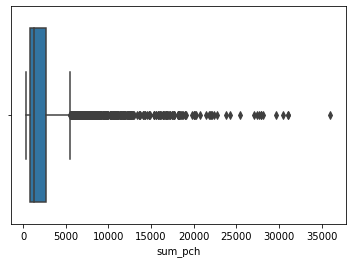

In [ ]:
sns.boxplot (df[df['sum_pch']>0]['sum_pch'])

In [ ]:
df[df['sum_pch'] >0].groupby('sum_pch').mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
sum_pch,,,,,,,
336.0,18.0,0.0,0.0,0.0,1.0,335.0,0.0
394.0,27.0,114.0,0.0,76.5,157.0,46.5,0.0
395.0,31.0,1.0,0.0,7.0,0.0,387.0,1.0
397.0,22.0,0.0,269.0,0.0,100.0,28.0,0.0
399.0,26.0,0.0,0.0,1.0,0.0,398.0,1.0
...,...,...,...,...,...,...,...
29608.0,36.0,29.0,12180.0,0.0,93.0,17306.0,0.0
30478.0,18.0,0.0,1878.0,0.0,18572.0,10028.0,0.0
31074.0,31.0,0.0,27723.0,3.0,202.0,3146.0,1.0


In [ ]:
dfins[dfins['LN']=='Adkinson']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
2762,2970_01,Earth,False,NaN,TRAPPIST-1e,NaN,False,740.0,82.0,6.0,NaN,1.0,Dwin Adkinson,2970,Adkinson
7281,7786_01,Earth,False,F/1616/P,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,45.0,3372.0,Stelle Adkinson,7786,Adkinson
12580,8497_01,Earth,False,G/1361/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,Bara Adkinson,8497,Adkinson


In [ ]:
dfins.groupby ('LN').aggregate (lambda x : tuple (x.unique())).filter(like = 'Adkinson', axis=0)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID
LN,,,,,,,,,,,,,,
Adkinson,"(2970_01, 7786_01, 8497_01)","(Earth,)","(False,)","(nan, F/1616/P, G/1361/S)","(TRAPPIST-1e,)","(nan, 38.0, 19.0)","(False,)","(740.0, 0.0)","(82.0, 0.0)","(6.0, 0.0)","(nan, 45.0, 0.0)","(1.0, 3372.0, 0.0)","(Dwin Adkinson, Stelle Adkinson, Bara Adkinson)","(2970, 7786, 8497)"


In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['CryoSleep'].value_counts () # Cryo не заисит от NID

(False,)              5327
(True,)               2480
(False, True)          615
(True, False)          552
(nan,)                 156
(False, nan)            32
(nan, False)            19
(True, nan)             19
(nan, True)             17
(True, False, nan)      17
(False, nan, True)      12
(False, True, nan)      12
(True, nan, False)      11
(nan, True, False)       7
(nan, False, True)       4
Name: CryoSleep, dtype: int64

In [ ]:
dff.groupby ('VRDeck').aggregate (lambda x : tuple (x.unique()))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,Name,NID,LN
VRDeck,,,,,,,,,,,,,,
0.0,"(0001_01, 0005_01, 0006_01, 0007_01, 0008_01, ...","(Europa, Earth, Mars, __)","(False, True, nan)","(B/0/P, F/0/P, F/2/S, F/3/S, B/1/P, __, F/3/P,...","(TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan)","(39.0, 44.0, 26.0, 35.0, 14.0, 34.0, 31.0, 27....","(False, nan, True)","(0.0, 42.0, 32.0, 1286.0, nan, 980.0, 1125.0, ...","(0.0, 483.0, 1539.0, 785.0, 122.0, 2.0, 225.0,...","(0.0, 3.0, 17.0, nan, 876.0, 69.0, 136.0, 1750...","(0, 291, 216, 998, 48, 990, 951, 2606, __, 468...","(Maham Ofracculy, Sandie Hinetthews, Billex Ja...","(0001, 0005, 0006, 0007, 0008, 0012, 0014, 001...","(Ofracculy, Hinetthews, Jacostaffey, Beston, F..."
1.0,"(0053_01, 0061_01, 0114_01, 0123_01, 0253_01, ...","(Earth, Europa, Mars, __)","(False, nan)","(F/11/S, F/12/S, G/20/S, F/27/P, G/42/P, F/51/...","(TRAPPIST-1e, 55 Cancri e, PSO J318.5-22, nan)","(25.0, 22.0, 27.0, 18.0, 29.0, 13.0, 61.0, 37....","(False, True, nan)","(0.0, 45.0, 82.0, 55.0, 272.0, 118.0, 1.0, 109...","(0.0, 1096.0, 157.0, 597.0, 615.0, 608.0, 2.0,...","(1938.0, 148.0, 429.0, 49.0, 0.0, 26.0, 863.0,...","(0, 1377, 238, 754, 3835, 34, 1, 252, 1197, 26...","(Elson Hickerson, Shanya Salez, Maura Beckerso...","(0053, 0061, 0114, 0123, 0253, 0267, 0395, 042...","(Hickerson, Salez, Beckerson, Fielson, Cardner..."
2.0,"(0004_01, 0128_01, 0283_02, 0327_01, 0403_01, ...","(Earth, Mars, Europa, __)","(False, nan)","(F/1/S, D/3/S, F/64/P, __, D/13/P, F/84/S, C/2...","(TRAPPIST-1e, nan, 55 Cancri e, PSO J318.5-22)","(16.0, 61.0, 22.0, 19.0, 43.0, 15.0, 79.0, 27....","(False, True, nan)","(303.0, 2353.0, 146.0, 17.0, 353.0, 2156.0, 0....","(70.0, 334.0, 654.0, 0.0, 896.0, 1111.0, 1268....","(151.0, 9.0, 1.0, 784.0, 0.0, 880.0, 863.0, 17...","(565, 316, 0, 59, 2210, 22, 33, 119, 250, 813,...","(Willy Santantines, Grohs Fles, Roydo Santin, ...","(0004, 0128, 0283, 0327, 0403, 0459, 0642, 084...","(Santantines, Fles, Santin, Ocherman, Wate, Ni..."
3.0,"(0056_03, 0398_01, 0547_01, 0656_01, 0688_01, ...","(Europa, Mars, Earth, __)","(False, nan)","(A/1/S, D/13/S, F/97/S, G/101/P, E/48/S, F/154...","(TRAPPIST-1e, 55 Cancri e, PSO J318.5-22, nan)","(27.0, 22.0, 23.0, 32.0, 34.0, 15.0, 20.0, 42....","(False, True, nan)","(279.0, 28.0, 0.0, 1973.0, 157.0, 1050.0, 2.0,...","(605.0, 420.0, 15.0, 0.0, 59.0, 25.0, 14.0, 39...","(3374.0, 36.0, 831.0, 0.0, 97.0, 714.0, 715.0,...","(286, 6011, 16, 768, 41, 0, 544, 787, 318, 806...","(Zinoces Tractive, Wales Tité, Trick Weavesend...","(0056, 0398, 0547, 0656, 0688, 0820, 0915, 100...","(Tractive, Tité, Weavesend, Gordond, Erpie, St..."
4.0,"(0313_01, 0368_01, 0465_02, 0471_02, 0527_01, ...","(Earth, Mars, Europa)","(False, nan)","(F/68/P, F/82/P, E/28/P, B/22/P, F/93/S, D/20/...","(PSO J318.5-22, TRAPPIST-1e, 55 Cancri e)","(60.0, 26.0, nan, 30.0, 33.0, 22.0, 46.0, 32.0...","(False, True, nan)","(7.0, 2832.0, 0.0, 1172.0, 1908.0, 784.0, 2492...","(540.0, 107.0, 654.0, 7972.0, 11.0, 33.0, 0.0,...","(1.0, 4447.0, 22.0, 0.0, 3.0, 601.0, 5.0, nan,...","(0, 15, 146, 1, 183, 1590, 136, 610, 769, 441,...","(Briney Mckinsond, Resers Perte, Kyley Chaelle...","(0313, 0368, 0465, 0471, 0527, 0568, 0581, 079...","(Mckinsond, Perte, Chaellerty, Fuelisent, Stit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19086.0,"(2493_02,)","(Europa,)","(False,)","(C/88/S,)","(PSO J318.5-22,)","(27.0,)","(True,)","(0.0,)","(11984.0,)","(1610.0,)","(709,)","(Markar Reelest,)","(2493,)","(Reelest,)"
20336.0,"(4594_02,)","(Europa,)","(False,)","(C/144/P,)","(TRAPPIST-1e,)","(31.0,)","(False,)","(0.0,)","(6670.0,)","(217.0,)","(625,)","(Tabiton Folhal,)","(4594,)","(Folhal,)"
22272.0,"(6467_01,)","(Europa,)","(False,)","(C/240/S,)","(55 Cancri e,)","(46.0,)","(False,)","(0.0,)","(9540.0,)","(nan,)","(0,)","(Majorab Diossiver,)","(6467,)","(Diossiver,)"


In [ ]:
dff.groupby ('LN').aggregate (lambda x : tuple (x.unique()))['CryoSleep'].value_counts () # Cryo не заисит от LN

(False, True)         934
(True, False)         613
(False,)              418
(True,)               160
(False, True, nan)     78
(True, False, nan)     57
(False, nan, True)     37
(False, nan)           30
(nan, False, True)     22
(nan, True, False)     14
(True, nan, False)     14
(nan, False)           10
(True, nan)             9
(nan,)                  6
(nan, True)             5
Name: CryoSleep, dtype: int64

In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['Destination'].value_counts () # Dest тоже не заисит от NID

(TRAPPIST-1e,)                                    5793
(55 Cancri e,)                                    1354
(PSO J318.5-22,)                                   826
(TRAPPIST-1e, 55 Cancri e)                         406
(55 Cancri e, TRAPPIST-1e)                         338
(nan,)                                             154
(TRAPPIST-1e, PSO J318.5-22)                       104
(PSO J318.5-22, TRAPPIST-1e)                        77
(TRAPPIST-1e, nan)                                  37
(nan, TRAPPIST-1e)                                  27
(55 Cancri e, PSO J318.5-22)                        21
(PSO J318.5-22, 55 Cancri e)                        18
(TRAPPIST-1e, PSO J318.5-22, 55 Cancri e)           16
(TRAPPIST-1e, 55 Cancri e, PSO J318.5-22)           14
(55 Cancri e, TRAPPIST-1e, PSO J318.5-22)           13
(55 Cancri e, PSO J318.5-22, TRAPPIST-1e)           12
(PSO J318.5-22, TRAPPIST-1e, 55 Cancri e)           10
(TRAPPIST-1e, 55 Cancri e, nan)                      9
(nan, 55 C

In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['LN']

NID
0001      (Ofracculy,)
0002          (Vines,)
0003         (Susent,)
0004    (Santantines,)
0005     (Hinetthews,)
             ...      
9276      (Noxnuther,)
9277      (Leonzaley,)
9278      (Mondalley,)
9279         (Connon,)
9280      (Hontichre,)
Name: LN, Length: 9280, dtype: object

In [ ]:
mask3 = dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['LN'].apply (lambda x : len (x) >1 )

In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['LN'][mask3]

NID
0020    (Brantuarez, Mcfaddennon, Jacostanley)
0047                            (Prucerod, __)
0064                                (__, Keen)
0082                               (Datte, __)
0092                        (Dunnisey, Hewson)
                         ...                  
9194                              (__, Subwor)
9205                             (Brakeng, __)
9208                           (__, Shieldson)
9220                   (Meyerthy, Barrilloney)
9238                       (Garnettiz, Emenez)
Name: LN, Length: 477, dtype: object

In [ ]:
mask4 = dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['LN'][mask3].apply (lambda x : not '__' in x)

In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['LN'][mask3][mask4] # в 341 из 9280 Nid проживают смешанные семьи, так что есть небольшая вероятность ошибки при заполнении

NID
0020    (Brantuarez, Mcfaddennon, Jacostanley)
0092                        (Dunnisey, Hewson)
0099                  (Leetersoney, Connelson)
0110                     (Aloubtled, Bootious)
0140                    (Mejiaddox, Whitakers)
                         ...                  
9155                        (Amoutake, Ingalt)
9157                         (Navages, Donson)
9162                   (Muspereed, Ineckethle)
9220                   (Meyerthy, Barrilloney)
9238                       (Garnettiz, Emenez)
Name: LN, Length: 341, dtype: object

In [ ]:
dff.groupby (['NID' , 'LN']).aggregate (lambda x : tuple (x.unique()))['Cabin']

NID   LN         
0001  Ofracculy         (B/0/P,)
0002  Vines             (F/0/S,)
0003  Susent            (A/0/S,)
0004  Santantines       (F/1/S,)
0005  Hinetthews        (F/0/P,)
                        ...     
9276  Noxnuther        (A/98/P,)
9277  Leonzaley      (G/1498/S,)
9278  Mondalley      (G/1499/S,)
9279  Connon         (G/1500/S,)
9280  Hontichre       (E/608/S,)
Name: Cabin, Length: 9716, dtype: object

In [ ]:
mask5 = dff.groupby (['NID' , 'LN']).aggregate (lambda x : tuple (x.unique()))['Cabin'].apply (lambda x : len (x) >1 ) # в 8% совпадения NID LN каюту не восстановить
dff.groupby (['NID' , 'LN']).aggregate (lambda x : tuple (x.unique()))['Cabin'][mask5]

NID   LN         
0006  Jacostaffey              (F/2/S, G/0/S)
0017  Brighttt                 (G/0/P, F/6/P)
0046  Powery                  (G/4/P, F/11/P)
0047  Prucerod                    (B/0/S, __)
0064  Keen                    (F/14/S, E/3/S)
                               ...           
9219  Workmanson         (G/1487/S, F/1783/S)
9231  Paie                (F/1888/P, E/592/P)
9238  Emenez         (G/1501/P, __, F/1890/P)
9266  Peter              (F/1796/S, G/1496/S)
9272  Simson             (G/1507/P, F/1894/P)
Name: Cabin, Length: 747, dtype: object

In [ ]:
mask = dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['Cabin'].apply (lambda x : len (x) >1 )

In [ ]:
dff.groupby ('NID').aggregate (lambda x : tuple (x.unique()))['Cabin'][mask]

NID
0006              (F/2/S, G/0/S)
0017              (G/0/P, F/6/P)
0046             (G/4/P, F/11/P)
0047                 (B/0/S, __)
0064             (F/14/S, E/3/S)
                  ...           
9220        (G/1496/P, F/1886/P)
9231         (F/1888/P, E/592/P)
9238    (G/1501/P, __, F/1890/P)
9266        (F/1796/S, G/1496/S)
9272        (G/1507/P, F/1894/P)
Name: Cabin, Length: 790, dtype: object

In [ ]:
dff.groupby (['NID' , 'LN']).aggregate (lambda x : tuple (x.unique()))['HomePlanet'].value_counts()

(Earth,)            5558
(Europa,)           2010
(Mars,)             1972
(Missed,)            174
(Europa, Missed)      26
(Earth, Missed)       23
(Mars, Missed)        20
(Missed, Earth)       16
(Missed, Mars)        15
(Missed, Europa)      13
Name: HomePlanet, dtype: int64

In [ ]:
dff1 = dff.groupby (['NID']).filter (lambda x : x['LN'].count() >1 )

In [ ]:
dff

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0001,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0002,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0003,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0003,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,0004,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266,Peter
4273,9269_01,Earth,False,__,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269,Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271,Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273,Conale


In [ ]:
dff1.groupby (['NID' , 'LN']).filter (lambda x : '__' in tuple (x['HomePlanet'].unique()) )

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
59,0064_02,__,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,0064,Keen
113,0119_01,__,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,0119,Coning
114,0119_02,Europa,True,A/0/P,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,0.0,0.0,Kleeiak Coning,0119,Coning
404,0444_01,Mars,False,D/15/P,TRAPPIST-1e,32.0,True,2484.0,429.0,102.0,0.0,0.0,Camonk Curte,0444,Curte
405,0444_02,__,False,F/99/P,TRAPPIST-1e,26.0,True,1869.0,0.0,136.0,0.0,0.0,Colal Curte,0444,Curte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159,9025_01,__,False,G/1454/S,TRAPPIST-1e,42.0,False,0.0,0.0,28.0,726.0,0.0,Ale Whitersone,9025,Whitersone
4160,9025_02,Earth,True,G/1454/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Philia Whitersone,9025,Whitersone
4213,9146_01,__,False,F/1874/P,TRAPPIST-1e,52.0,False,994.0,0.0,173.0,0.0,24.0,Rionk Sache,9146,Sache
4214,9146_02,Mars,False,D/293/P,TRAPPIST-1e,28.0,False,1014.0,81.0,1.0,85.0,1.0,Cran Sache,9146,Sache


In [ ]:
dff1['HomePlanet'].value_counts()

Earth     2292
Europa    2071
Mars      1329
__         133
Name: HomePlanet, dtype: int64

In [ ]:
mask2 = dff.groupby (['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin'].apply (lambda x : len(x) >1 )

In [ ]:
len (dff.groupby (['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin'][mask2] )/ len (dff.groupby (['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin'])

0.07357280960618703

In [ ]:
dff.groupby (['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin'][mask2] # семьи могут жить в разных каютах, но если также совпадает NID, то 92%, что одна фамилия

LN           NID 
Acobson      6905         (F/1322/S, E/460/S)
Acobsond     5873          (G/952/P, E/372/P)
Adavisons    1425          (F/282/P, G/220/P)
Airdring     3580          (D/114/S, B/138/S)
Alfordonard  1221           (G/188/S, E/87/S)
                               ...           
Yanton       5127          (G/837/S, F/983/S)
Yorkland     0091            (G/16/S, F/20/S)
             0461    (E/27/S, F/85/S, G/66/S)
             0618           (G/95/P, F/131/P)
Youngrayes   4761          (G/770/P, F/967/P)
Name: Cabin, Length: 723, dtype: object

In [ ]:
dff.groupby (['LN' , 'NID']).aggregate (lambda x : tuple (x.unique()))['Cabin']

LN          NID 
Acobson     4220             (E/263/P,)
            4353             (F/817/S,)
            6905    (F/1322/S, E/460/S)
Acobsond    0991             (G/152/S,)
            1459             (F/281/S,)
                           ...         
Youngrayes  0960              (E/72/S,)
            2264             (F/442/S,)
            2369             (F/484/P,)
            4761     (G/770/P, F/967/P)
            5866            (F/1211/P,)
Name: Cabin, Length: 9827, dtype: object

In [ ]:
dff1.groupby ('NID' ).filter (lambda x : '__' in tuple (x['LN'].unique()) )

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0064,__
59,0064_02,__,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,0064,Keen
75,0082_01,Mars,False,F/16/P,TRAPPIST-1e,42.0,False,7406.0,0.0,0.0,0.0,0.0,Totse Datte,0082,Datte
76,0082_02,Mars,True,F/16/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Eaturs Datte,0082,Datte
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0082,__
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,8800_04,Earth,False,G/1423/P,TRAPPIST-1e,19.0,False,13.0,905.0,861.0,0.0,0.0,Carley Nolds,8800,Nolds
4049,8800_05,Earth,False,G/1423/P,PSO J318.5-22,12.0,False,0.0,0.0,0.0,0.0,0.0,Carona Nolds,8800,Nolds
4073,8873_01,Europa,False,A/93/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Altar Unregul,8873,Unregul
4074,8873_02,Europa,False,A/93/P,TRAPPIST-1e,36.0,NaN,0.0,3973.0,18.0,5188.0,543.0,NaN,8873,__


In [ ]:
dff[dff['NID'] == '6383'] 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
2901,6383_01,Earth,True,G/1035/S,TRAPPIST-1e,0.0,False,0.0,0.0,NaN,0.0,0.0,NaN,6383,__
2902,6383_02,Earth,False,G/1035/S,55 Cancri e,12.0,False,0.0,0.0,NaN,0.0,0.0,Kendre Sterreray,6383,Sterreray
2903,6383_03,Earth,False,G/1035/S,PSO J318.5-22,37.0,False,18.0,0.0,646.0,6.0,102.0,NaN,6383,__


In [ ]:
dff1[dff1['NID'] == '6383'] 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,NID,LN
2901,6383_01,Earth,True,G/1035/S,TRAPPIST-1e,0.0,False,0.0,0.0,NaN,0.0,0.0,NaN,6383,__
2902,6383_02,Earth,False,G/1035/S,55 Cancri e,12.0,False,0.0,0.0,NaN,0.0,0.0,Kendre Sterreray,6383,Sterreray
2903,6383_03,Earth,False,G/1035/S,PSO J318.5-22,37.0,False,18.0,0.0,646.0,6.0,102.0,NaN,6383,__


In [ ]:
df.groupby (['LN' , 'NID']).mean ()['Transported'].value_counts() # если фамилии и NID совпадают в 90% случаях (на трейне) можно точно предсказать метку класса

0.000000    3057
1.000000    2806
0.500000     426
0.666667     123
0.333333      81
0.750000      25
0.250000      13
0.800000      10
0.600000      10
0.400000       7
0.833333       5
0.200000       5
0.571429       4
0.428571       4
0.166667       3
0.285714       3
0.125000       1
0.714286       1
0.375000       1
0.857143       1
0.625000       1
Name: Transported, dtype: int64

In [ ]:
df.groupby('LN').filter (lambda x : x['LN'].count() ==1)['Transported'].mean() # шансы одиночек выжить побольше (но это без учета незаполненных имен, надо повторить после заполнения)

0.5837696335078534

In [ ]:
len (dff['LN'].unique())

2407

## Итак, восстановим пропущенные значения:  
- LN (используя связку NID и Cabin)
-  Home (используя сначала NID, потом LN )
- Cabin (используя связку NID и LN)


Признак NID закодируем Catboost Encoder /Target Encoders    
признак Name оставим и закодируем BinVect  
Поробуем признак - одиночка

Ч2: 
- заполняем Cryo исходя из затрат (есть затраты == False)
- в группе неспящих больше 21 года, пропуски в затратах заполняем единицами
- пробуем ввести бинарный признак трат (sum_pc  > 0) 
- пробуем сбросить (а не заполнять imputerom неочевидные признаки)


ч.3 пробуем заполнить пропуски на основе гипотез и вероятнстых моделей 

In [ ]:
dff.isna().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
NID               0
LN              294
dtype: int64

In [ ]:
dff = dff.drop (['PassengerId' , 'Name'] , axis=1)

In [ ]:
dff['Destination'].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [ ]:
# сначала заполняем VIP он малозначим и веротяность 90%
dff['VIP'] = dff['VIP'].fillna(False)
#dff['Destination'] = dff['Destination'].fillna('TRAPPIST-1e')

In [ ]:
# затем восстанавливаем 'HomePlanet' ,'Cabin' , 'LN' 
dff[['HomePlanet' ,'Cabin' , 'LN' ]] = dff[['HomePlanet' ,'Cabin' , 'LN' ]].fillna ('__')

In [ ]:
#ln = dff['LN'].unique()
f = 'LN'
tdff = dff[dff[f] == '__' ]
nid = tdff['NID'].unique()

In [ ]:
for n in nid:
 #   print (n)
    if len (dff[dff['NID'] == n]) > 1 :
      if dff[dff['NID'] == n][f].nunique() <3 :
         dff[f].loc[dff['NID'] == n] = dff[dff['NID'] == n][f].apply ( lambda x :  dff[dff['NID'] == n][f].sort_values ().iloc[0])



In [ ]:
f = 'Cabin'
tdff = dff[dff[f] == '__' ]
nid = tdff['NID'].unique()


In [ ]:
for n in nid:
 #   print (n)
    if len (dff[dff['NID'] == n]) > 1 :
      if dff[dff['NID'] == n][f].nunique() <3 :
         dff[f].loc[dff['NID'] == n] = dff[dff['NID'] == n][f].apply ( lambda x :  dff[dff['NID'] == n][f].sort_values ().iloc[0])
 #     else : 
 #       print ('Error' , n)

In [ ]:
f = 'HomePlanet'
tdff = dff[dff[f] == '__' ]
nid = tdff['LN'].unique()

In [ ]:
for n in nid:
 #   print (n)
    if len (dff[dff['LN'] == n]) > 1 :
      if  dff[dff['LN'] == nid[0]][f].sort_values ().iloc[0] != '__' :
         dff[f].loc[dff['LN'] == n] = dff[dff['LN'] == n][f].apply ( lambda x :  dff[dff['LN'] == n][f].sort_values ().iloc[0])
 #   else : 
 #       print ('One' , n)

In [ ]:
# теперь 'Cryo' 

In [ ]:
dff['s_pch1'] = dff['ShoppingMall'] + dff['FoodCourt'] + dff['RoomService'] + dff['Spa'] + dff['VRDeck']

In [ ]:
dff['s_pch'] = dff.iloc[:, 6:11].sum(axis=1 )

In [ ]:
mask = dff[dff['CryoSleep'].isna()]['s_pch'] >0 # фильтр по тем, кто тратил хоть что-то

In [ ]:
ix1 = dff[dff['CryoSleep'].isna()][mask].index # их сразу записываекм в неспящие
dff['CryoSleep'].loc[ix1] = False

In [ ]:
dff['CryoSleep'].value_counts()

False    8253
True     4581
Name: CryoSleep, dtype: int64

In [ ]:
ix2 = dff[dff['CryoSleep'].isna()][(dff[dff['CryoSleep'].isna()]['Age'] > 21 ) &(dff[dff['CryoSleep'].isna()]['s_pch1'] ==0) ].index 
dff['CryoSleep'].loc[ix2] = True # ставим фильтр в пропущенном крио по тем, кто ничего не тратит и тем кому более 21 года, их записываем в спящие 

In [ ]:
# заполняем нулями пропуски трат у спящих
dff_cr = dff[dff['CryoSleep']==True]
ix3 =  dff_cr[dff_cr['RoomService'].isna()].index
ix4 =  dff_cr[dff_cr['FoodCourt'].isna()].index
ix5 =  dff_cr[dff_cr['ShoppingMall'].isna()].index
ix6 = dff_cr[dff_cr['Spa'].isna()].index
ix7 = dff_cr[dff_cr['VRDeck'].isna()].index
dff['RoomService'].loc[ix3] = 0
dff['FoodCourt'].loc[ix4] = 0
dff['ShoppingMall'].loc[ix5] = 0
dff['Spa'].loc[ix6] = 0
dff['VRDeck'].loc[ix7] = 0

In [ ]:
df_pc = dff[  (dff['s_pch1'].isna()) & (dff['s_pch']!=0)]  # филтруем тех, кто тратит, но имеет пропуски в тратах, заполняем их 1 
ix8 = df_pc[df_pc['RoomService'].isna()].index
ix9 = df_pc[df_pc['FoodCourt'].isna()].index
ix10 = df_pc[df_pc['ShoppingMall'].isna()].index
ix11 = df_pc[df_pc['Spa'].isna()].index
ix12 = df_pc[df_pc['VRDeck'].isna()].index
dff['RoomService'].loc[ix8] = 1
dff['FoodCourt'].loc[ix9] = 1
dff['ShoppingMall'].loc[ix10] = 1
dff['Spa'].loc[ix11] = 1
dff['VRDeck'].loc[ix12] = 1


In [ ]:
dff.isna().sum()

HomePlanet         0
CryoSleep         69
Cabin              0
Destination      274
Age              270
VIP                0
RoomService       14
FoodCourt         13
ShoppingMall      15
Spa               15
VRDeck            34
NID                0
LN                 0
s_pch1          1363
s_pch              0
dtype: int64

In [ ]:
# доразбираемся с числовыми признаками
dff['s_pch1'] = dff['ShoppingMall'] + dff['FoodCourt'] + dff['RoomService'] + dff['Spa'] + dff['VRDeck']
#dff[dff['s_pch1'].isna()]

In [ ]:
dff[dff['VRDeck']==dff['s_pch1']][dff[dff['VRDeck']==dff['s_pch1']]['s_pch1'] !=0] # 99% тратят сразу в нескольких категориях, поэтому заполняем нулями Nan в нулевых строках


In [ ]:
# также у нас есть несколько строк с нулями и нескольками Nan в строке, их мало поэтому тоже заполним нулями для удобства
ix13 = dff[dff['s_pch1'].isna()].index
dff['ShoppingMall'].loc[ix13] = 0.0
dff['FoodCourt'].loc[ix13] = 0.0
dff['RoomService'].loc[ix13] = 0.0
dff['Spa'].loc[ix13] = 0.0
dff['VRDeck'].loc[ix13] = 0.0

In [ ]:
dff.isna().sum()

HomePlanet        0
CryoSleep        69
Cabin             0
Destination     274
Age             270
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
NID               0
LN                0
s_pch1           86
s_pch             0
dtype: int64

In [ ]:
# теперь доразберемся с CryoSleep, после заполнения nan в тратах еще несколько взрослых добавим
ix14 = dff['CryoSleep'][dff['CryoSleep'].isna()][dff[dff['CryoSleep'].isna()]['Age']>21].index
dff['CryoSleep'].loc[ix14] =True

In [ ]:
# получим скор на этом этапе 0.803 (0.806 c num_imputer трат)

In [ ]:
cr_nan = dff.groupby (['LN' ,'NID']).filter (lambda x : np.nan in tuple (x['CryoSleep'].unique()))

In [ ]:
#cr_nan = dff.groupby (['LN' ,'NID', 'Cabin' ]).filter (lambda x : '__' in tuple (x['CryoSleep'].unique()))

In [ ]:
# заполняем Cryo по комбо LN NID
f = 'CryoSleep'
nid = cr_nan['NID'].unique()
nil = cr_nan['LN'].unique()

In [ ]:
for n , l in zip (nid, nil):
    tdf = dff[(dff['NID'] == n) & (dff['LN'] == l)]
    if len (tdf) > 1 :
     if  len (set (tdf['LN'].values)) <2:
      if tdf[f].nunique(dropna=False) <3 :
         dff[f].loc[(dff['NID'] == n) & (dff['LN'] == l)] = tdf[f].apply ( lambda x :  tdf[f].sort_values ().iloc[0])
      else : 
        print ('Error_' , n)

Error_ 1624
Error_ 3301
Error_ 3439
Error_ 4680
Error_ 4741
Error_ 5090
Error_ 6405


In [ ]:
df.groupby (['NID' , 'LN']).mean()['Transported'].value_counts()

In [ ]:
dff['CryoSleep'].loc[dff[dff['CryoSleep'].isna()].index]

In [ ]:
# оставшиеся Cryo заполняем True потому что расходы нулевые
ix15 =  dff[dff['CryoSleep'].isna()].index
dff['CryoSleep'].loc[ix15] = True

In [ ]:
# пробуем скор на этом этапе 0.808

In [ ]:
# Пропуски Cabin заполняем палубой F. как ниболее массовой
dff['Cabin'][dff['Cabin']== "__"] = 'F'

In [ ]:
dff.groupby (['LN' ,'NID', 'Cabin']).agg (lambda x : tuple (x.unique()))['Destination'].value_counts() # 93% Cabin имеют одинаковый Dest, но 193 полностю nan

(TRAPPIST-1e,)                                    6722
(55 Cancri e,)                                    1615
(PSO J318.5-22,)                                   940
(TRAPPIST-1e, 55 Cancri e)                         331
(55 Cancri e, TRAPPIST-1e)                         303
(nan,)                                             193
(TRAPPIST-1e, PSO J318.5-22)                        69
(PSO J318.5-22, TRAPPIST-1e)                        67
(TRAPPIST-1e, nan)                                  25
(55 Cancri e, PSO J318.5-22)                        23
(nan, TRAPPIST-1e)                                  20
(PSO J318.5-22, 55 Cancri e)                        14
(TRAPPIST-1e, PSO J318.5-22, 55 Cancri e)           12
(TRAPPIST-1e, 55 Cancri e, nan)                      7
(nan, 55 Cancri e)                                   5
(55 Cancri e, nan)                                   5
(TRAPPIST-1e, PSO J318.5-22, nan)                    5
(PSO J318.5-22, 55 Cancri e, TRAPPIST-1e)            4
(55 Cancri

In [ ]:
dff.groupby (['LN' ,'NID']).agg (lambda x : tuple (x.unique()))['Destination'].value_counts() # на уровыне NID уже 87% и всеще много nan полностью

In [ ]:
# разные 
dff.groupby (['LN' ,'NID', 'Cabin']).filter (lambda x : np.nan in tuple (x['Destination'].unique())).groupby('LN').apply (lambda x : tuple (x['Destination'].unique()) ).value_counts()

(nan,)                                            174
(TRAPPIST-1e, nan)                                 25
(nan, TRAPPIST-1e)                                 20
(TRAPPIST-1e, 55 Cancri e, nan)                     7
(nan, 55 Cancri e)                                  5
(55 Cancri e, nan)                                  5
(TRAPPIST-1e, PSO J318.5-22, nan)                   4
(55 Cancri e, TRAPPIST-1e, nan)                     3
(TRAPPIST-1e, nan, 55 Cancri e)                     3
(PSO J318.5-22, nan)                                2
(55 Cancri e, nan, TRAPPIST-1e)                     2
(nan, PSO J318.5-22, TRAPPIST-1e)                   1
(TRAPPIST-1e, nan, PSO J318.5-22)                   1
(PSO J318.5-22, TRAPPIST-1e, nan, 55 Cancri e)      1
(nan, PSO J318.5-22)                                1
(nan, TRAPPIST-1e, PSO J318.5-22)                   1
dtype: int64

In [ ]:
df[df['Destination']=='55 Cancri e']['Transported'].mean() # Dest 55 Cancri e влияет на выживаемость, TRAPPIST-1e чутть меньше, но тоже, PSO J318.5-22 никак не влияет, имеет смысл для заволнения

0.61

In [ ]:
# пробуем скор на этом этапе 0.8071

In [ ]:
# заполняем Dest по аналогии комбо LN NID
dest_nan = dff.groupby (['LN' ,'NID']).filter (lambda x : np.nan in tuple (x['Destination'].unique()))

In [ ]:
f = 'Destination'
nid = dest_nan['NID'].unique()
nil = dest_nan['LN'].unique()
for n , l in zip (nid, nil):
    tdf = dff[(dff['NID'] == n) & (dff['LN'] == l)]
    if len (tdf) > 1 :
      if tdf[f].nunique(dropna=False) <3 :
         dff[f].loc[(dff['NID'] == n) & (dff['LN'] == l)] = tdf[f].apply ( lambda x :  tdf[f].sort_values ().iloc[0])
      else : 
        print ('Error_' , n)

Error_ 0504
Error_ 0564
Error_ 0714
Error_ 1148


In [ ]:
dff[dff['NID'] == '1148']

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,NID,LN,s_pch1,s_pch
1072,Europa,True,C/42/P,55 Cancri e,22.0,False,0.0,0.0,0.0,0.0,0.0,1148,Clugete,0.0,0.0
1073,Europa,False,C/42/P,55 Cancri e,NaN,False,0.0,122.0,2138.0,7368.0,1213.0,1148,Clugete,10841.0,10841.0
1074,Europa,False,C/42/P,TRAPPIST-1e,30.0,False,0.0,5225.0,0.0,8.0,1933.0,1148,Clugete,7166.0,7166.0
1075,Europa,False,C/42/P,55 Cancri e,39.0,False,0.0,5212.0,2.0,118.0,61.0,1148,Clugete,5393.0,5393.0
1076,Europa,True,C/42/P,NaN,14.0,False,0.0,0.0,0.0,0.0,0.0,1148,Clugete,0.0,0.0
1077,Europa,True,C/42/P,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,1148,Clugete,0.0,0.0
1078,Europa,False,C/42/P,55 Cancri e,34.0,False,2386.0,841.0,76.0,26.0,1693.0,1148,Clugete,5022.0,5022.0


In [ ]:
dff[dff['Destination']=='PSO J318.5-22']['CryoSleep'].mean()

0.4936708860759494

In [ ]:
dff[dff['Destination'].isna()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,NID,LN,s_pch1,s_pch
139,Earth,False,F/32/P,NaN,41.0,False,0.0,0.0,0.0,0.0,607.0,0152,Estron,607.0,607.0
347,Earth,False,G/64/P,NaN,23.0,False,348.0,0.0,0.0,4.0,368.0,0382,Floydendley,720.0,720.0
430,Earth,True,G/67/S,NaN,50.0,False,0.0,0.0,0.0,0.0,0.0,0462,Sosanturney,0.0,0.0
468,Europa,True,B/19/S,NaN,24.0,False,0.0,0.0,0.0,0.0,0.0,0504,Unpasine,0.0,0.0
529,Europa,False,B/24/P,NaN,28.0,False,0.0,410.0,2.0,1354.0,3695.0,0564,Dinsprody,5461.0,5461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,Earth,True,F/1748/S,NaN,0.0,False,0.0,0.0,0.0,0.0,0.0,9022,Boyerson,0.0,0.0
12856,Earth,True,G/1468/P,NaN,23.0,False,0.0,0.0,0.0,0.0,0.0,9039,Wilkinner,0.0,0.0
12889,Earth,False,G/1478/P,NaN,31.0,False,0.0,0.0,1.0,0.0,198.0,9095,Reynoldez,199.0,198.0
12912,Europa,False,C/304/P,NaN,17.0,False,149.0,2045.0,1.0,1872.0,0.0,9155,Amoutake,4067.0,4066.0
